In [2]:
%reset
import numpy as np 
import pandas as pd 
import xarray as xr 
import cartopy 
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import warnings
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.offsetbox as offsetbox
warnings.filterwarnings("ignore")
#from sklearn_xarray import Stacker, Select

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Shortcut 

[Latest cell](#working_cell)

# Load Data

In [3]:
root_path='/data/keeling/a/rytam2/ccf_model_spread/data/preprocessed/'
kernel_path='/data/keeling/a/rytam2/a/kernels/gcms/'

In [4]:
ts = xr.open_mfdataset(root_path+'ts_obshist_CMIP5&6_2008.nc')
eis = xr.open_mfdataset(root_path+'eis_obshist_CMIP5&6_2008.nc')
tadv = xr.open_mfdataset(root_path+'tadv_obshist_CMIP5&6_2008.nc')*24*3600
rh = xr.open_mfdataset(root_path+'hur_obshist_CMIP5&6_2008.nc')
omega = xr.open_mfdataset(root_path+'wap_obshist_CMIP5&6_2008.nc')*864
ws = xr.open_mfdataset(root_path+'ws_obshist_CMIP5&6_2008.nc')

In [5]:
kernels_list = glob.glob(kernel_path+'*.nc');

modelname_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl',
                'mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm'] #order must be sticktly followed to match kernels_list
cmip5_list=['ccsm4','canam4','hg2','miesm','mi5','mpi','mrcgcm']
cmip6_list=['canesm5','e3sm','gfdl','hg3','ipsl','mi6','mies2l','mresm','ukesm']

dict_sst_kernels = {}
dict_eis_kernels = {}
dict_tadv_kernels = {}
dict_rh_kernels = {}
dict_omega_kernels = {}
dict_ws_kernels = {}

for filename in kernels_list:
    kernel=xr.open_mfdataset(filename)
    j = kernels_list.index(filename)
    modelname=modelname_list[j]
    dict_sst_kernels["%s"%modelname] = kernel.isel(i=0).dRdxi
    dict_eis_kernels["%s"%modelname] = kernel.isel(i=1).dRdxi
    dict_tadv_kernels["%s"%modelname] = kernel.isel(i=2).dRdxi
    dict_rh_kernels["%s"%modelname] = kernel.isel(i=3).dRdxi
    dict_omega_kernels["%s"%modelname] = kernel.isel(i=4).dRdxi
    dict_ws_kernels["%s"%modelname] = kernel.isel(i=5).dRdxi
    
coords = {'lat':(['latitude'],kernel.lat.values),
         'lon':(['longitude'],kernel.lon.values)}

sst_kernels = xr.Dataset(data_vars=dict_sst_kernels,coords=coords);
eis_kernels = xr.Dataset(data_vars=dict_eis_kernels,coords=coords);
tadv_kernels = xr.Dataset(data_vars=dict_tadv_kernels,coords=coords);
rh_kernels = xr.Dataset(data_vars=dict_rh_kernels,coords=coords);
omega_kernels = xr.Dataset(data_vars=dict_omega_kernels,coords=coords);
ws_kernels = xr.Dataset(data_vars=dict_ws_kernels,coords=coords);

#rename dims for easier manipulation 
sst_kernels = sst_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
eis_kernels = eis_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
tadv_kernels = tadv_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
rh_kernels = rh_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
omega_kernels = omega_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
ws_kernels = ws_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});

# Remove Seasonality

In [6]:
# Remove seasonal cycle from measurements 
def remove_seasonality(x):
    return x - x.mean(dim='time')


ts_noseason = ts.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1982.0,2009,1/12)}) #set decimal year 
eis_noseason = eis.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1982.0,2009,1/12)}) #set decimal year
tadv_noseason = tadv.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1982.0,2009,1/12)}) #set decimal year 
rh_noseason = rh.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1982.0,2009,1/12)}) #set decimal year 
omega_noseason = omega.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1982.0,2009,1/12)}) #set decimal year 
ws_noseason = ws.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1982.0,2009,1/12)}) #set decimal year 

## Regression Coefficient $\beta$ and $\hat{dX_{i}}$ at all location

In [7]:
# Remove seasonal cycle from measurements 
def approx_change(x,degree):
    if degree == 1: 
        poly=x.polyfit(dim='time', deg=1)
        fit = xr.polyval(x['time'],poly.polyfit_coefficients)
        change = fit.isel(time=-1)-fit.isel(time=0)
        return change
    
def normalize(x): 
    glob = x.mean('lat').mean('lon')
    norm = x/glob
    return x

def ensemble_mean(x):
    return x.to_array(dim='models').mean('models')

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return

In [8]:
# Get approximated change in CCF across period 

da_list=[approx_change(ts_noseason[var],1).rename(var) for var in modelname_list]
dSST_hat = xr.merge(da_list)
da_list=[approx_change(eis_noseason[var],1).rename(var) for var in modelname_list]
dEIS_hat = xr.merge(da_list)
da_list=[approx_change(tadv_noseason[var],1).rename(var) for var in modelname_list]
dTadv_hat = xr.merge(da_list)
da_list=[approx_change(rh_noseason[var],1).rename(var) for var in modelname_list]
dRH_hat = xr.merge(da_list)
da_list=[approx_change(omega_noseason[var],1).rename(var) for var in modelname_list]
dOmega_hat = xr.merge(da_list)
da_list=[approx_change(ws_noseason[var],1).rename(var) for var in modelname_list]
dWS_hat = xr.merge(da_list)

## Calculate $dX_{i}$ (compared to benchmark) 

## $dR_{ij}$ (per CCF, per ensemble member)

In [9]:
dR_SST_hat = dSST_hat * sst_kernels
dR_EIS_hat = dEIS_hat * eis_kernels
dR_Tadv_hat = dTadv_hat * tadv_kernels
dR_RH_hat = dRH_hat * rh_kernels
dR_Omega_hat = dOmega_hat * omega_kernels
dR_WS_hat = dWS_hat * ws_kernels

# Ensemble Mean of dCCF_hat
dR_SST_hat_bar = ensemble_mean(dR_SST_hat)
dR_EIS_hat_bar = ensemble_mean(dR_EIS_hat)
dR_Tadv_hat_bar = ensemble_mean(dR_Tadv_hat)
dR_RH_hat_bar = ensemble_mean(dR_RH_hat)
dR_Omega_hat_bar = ensemble_mean(dR_Omega_hat)
dR_WS_hat_bar = ensemble_mean(dR_WS_hat)

## $dR$ (sum of all CCFs per ensemble member) 

In [10]:
dR_hat = dR_SST_hat + dR_EIS_hat + dR_Tadv_hat + dR_RH_hat + dR_Omega_hat + dR_WS_hat

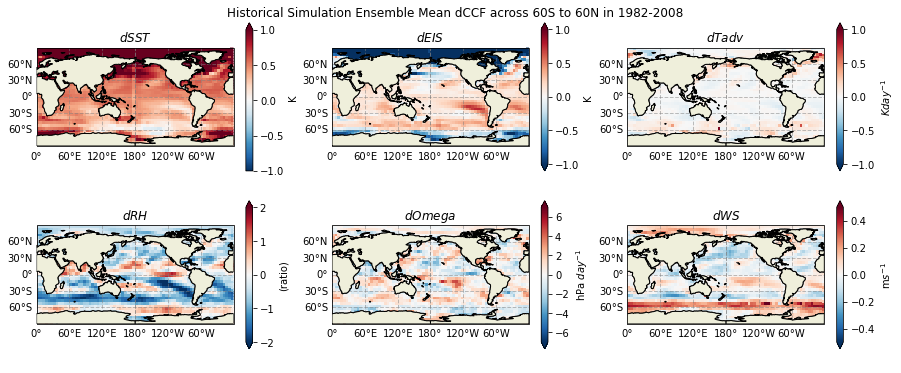

In [10]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dSST_hat.to_array(dim='models').mean('models').plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdBu_r',cbar_kwargs=dict(label='K'), vmax=1,vmin=-1)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
im = dEIS_hat.to_array(dim='models').mean('models').plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdBu_r', extend='both', cbar_kwargs=dict(label='K'), vmax=1,vmin=-1)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dTadv_hat.to_array(dim='models').mean('models').plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both',cbar_kwargs=dict(label='$K day^{-1}$'), vmax=1,vmin=-1)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dRH_hat.to_array(dim='models').mean('models').plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both',cbar_kwargs=dict(label='(ratio)'), vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dOmega_hat.to_array(dim='models').mean('models').plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both',cbar_kwargs=dict(label='hPa $day^{-1}$'), vmax=7,vmin=-7)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
dWS_hat.to_array(dim='models').mean('models').plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdBu_r', extend='both', cbar_kwargs=dict(label='m$s^{-1}$'), vmax=.5,vmin=-.5)#,add_colorbar=False, extend=True, vmax=0.1,vmin=-0.1)
ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
#fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} Trend$ ($Wm^{-2} yr^{-1}$)',ticks=np.arange(-0.1,0.125,0.025),extend='both')

ax.set_title('Historical Simulation Ensemble Mean dCCF across 60S to 60N in 1982-2008')
ax1.set_title('$dSST$')
ax2.set_title('$dEIS$')
ax3.set_title('$dTadv$')
ax4.set_title('$dRH$')
ax5.set_title('$dOmega$')
ax6.set_title('$dWS$')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/dCCF_bar_across_all_6maps_singcolorbar_hist_cartopy.png', dpi=300,bbox_inches='tight')

# Calculate contributions of CCFs to dR' 

### Ensemble Mean Change by dXi ($dR_{X}$)

#### Average of all models by taking dR_ensemble mean 

#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
ax.coastlines()


beta_dR_Total_bar.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='RdYlBu_r',extend='both', cbar_kwargs={'ticks':np.arange(-0.15,0.2,0.05),'shrink': 0.75,'label':'$dR_{\u03A3 CCF} Trend $ ($Wm^{-2}yr^{-1}$)'},vmin=-.15,vmax=.15)

ax.set_title('Ensemble Mean Trend of $dR_{\u03A3 CCF}$ across 60S to 60N (1982-2008)')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/2008/final/dR_trend_ensemble_mean_total_2008_cartopy.png', dpi=300,bbox_inches='tight')

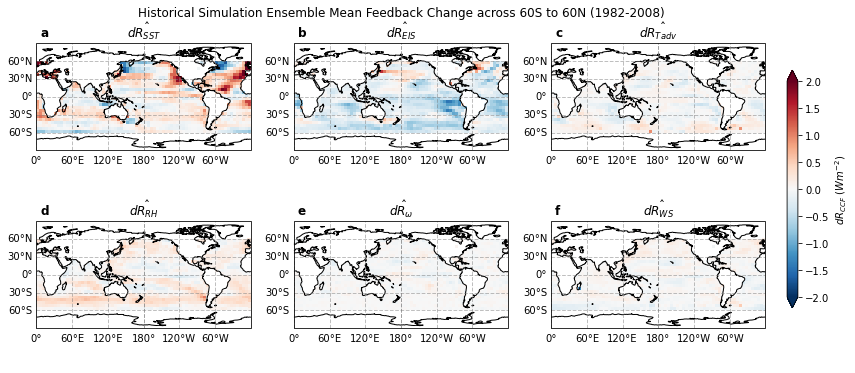

In [19]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

dR_SST_hat_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='RdBu_r',add_colorbar=False,vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
im = dR_EIS_hat_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='RdBu_r',add_colorbar=False,vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
dR_Tadv_hat_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False,vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
dR_RH_hat_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False,vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
dR_Omega_hat_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False,vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
dR_WS_hat_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='RdBu_r',add_colorbar=False,vmax=2,vmin=-2)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} $ ($Wm^{-2}$)',ticks=np.arange(-2,2.5,.5),extend='both')

ax.set_title('Historical Simulation Ensemble Mean Feedback Change across 60S to 60N (1982-2008)')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/dRi_hat_bar_across_models_6maps_singcolorbar_hist_2008_cartopy.png', dpi=300,bbox_inches='tight')

##  $\hat{dR_{i}}$ SD across models (calculated with approximated $dX_{i}$ (i.e. $\hat{dX_{i}}$))

In [11]:
std_dR_SST_bar = dR_SST_hat.to_array(dim='models').std('models')
std_dR_EIS_bar = dR_EIS_hat.to_array(dim='models').std('models')
std_dR_Tadv_bar = dR_Tadv_hat.to_array(dim='models').std('models')
std_dR_RH_bar = dR_RH_hat.to_array(dim='models').std('models')
std_dR_Omega_bar = dR_Omega_hat.to_array(dim='models').std('models')
std_dR_WS_bar = dR_WS_hat.to_array(dim='models').std('models')
std_dR_bar = dR_hat.to_array(dim='models').std('models')

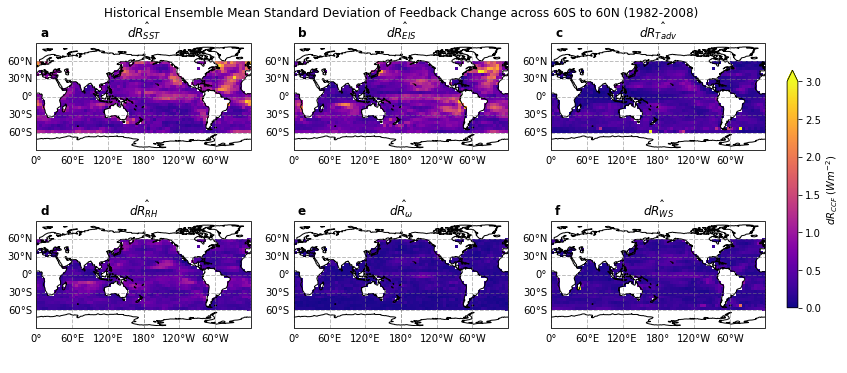

In [12]:
#figcheck 
fig = plt.figure(figsize=[15,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(232,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = fig.add_subplot(235,projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines()

std_dR_SST_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=3,vmin=0)#,add_colorbar=False, extend=True)
im = std_dR_EIS_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=3,vmin=0)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
std_dR_Tadv_bar.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=3,vmin=0)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
std_dR_RH_bar.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=3,vmin=0)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
std_dR_Omega_bar.plot(ax=ax5,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=3,vmin=0)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)
std_dR_WS_bar.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=3,vmin=0)#,add_colorbar=False, extend=True, vmax=0.2,vmin=-0.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{CCF} $ ($Wm^{-2}$)',ticks=np.arange(0,4,.5),extend='max')

ax.set_title('Historical Ensemble Mean Standard Deviation of Feedback Change across 60S to 60N (1982-2008)')
ax1.set_title('$\hat{dR_{SST}}$')
ax2.set_title('$\hat{dR_{EIS}}$')
ax3.set_title('$\hat{dR_{Tadv}}$')
ax4.set_title('$\hat{dR_{RH}}$')
ax5.set_title('$\hat{dR_{\u03c9}}$')
ax6.set_title('$\hat{dR_{WS}}$')
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/std_dR_hat_across_models_hist_2008_cartopy.png', dpi=300,bbox_inches='tight')

# Uncertainty Analysis 

In [14]:
# Model Averaged values 
dSST_bar = ensemble_mean(dSST_hat)
dEIS_bar = ensemble_mean(dEIS_hat)
dTadv_bar = ensemble_mean(dTadv_hat)
dRH_bar = ensemble_mean(dRH_hat)
dOmega_bar = ensemble_mean(dOmega_hat)
dWS_bar = ensemble_mean(dWS_hat)
sst_kernels_bar = ensemble_mean(sst_kernels)
eis_kernels_bar = ensemble_mean(eis_kernels)
tadv_kernels_bar = ensemble_mean(tadv_kernels)
rh_kernels_bar = ensemble_mean(rh_kernels)
omega_kernels_bar = ensemble_mean(omega_kernels)
ws_kernels_bar = ensemble_mean(ws_kernels)

#Model deviations 
dEIS_prime = dEIS_hat - dEIS_bar
dTadv_prime = dTadv_hat - dTadv_bar
dRH_prime = dRH_hat - dRH_bar
dOmega_prime = dOmega_hat - dOmega_bar
dWS_prime = dWS_hat - dWS_bar

# kernel deviation from mean 
sst_kernels_prime = sst_kernels-sst_kernels_bar
eis_kernels_prime = eis_kernels-eis_kernels_bar
tadv_kernels_prime = tadv_kernels-tadv_kernels_bar
rh_kernels_prime = rh_kernels-rh_kernels_bar
omega_kernels_prime = omega_kernels-omega_kernels_bar
ws_kernels_prime = ws_kernels-ws_kernels_bar

## Assumption of dR = dX_bar* kernel_prime + dX_prime*kernel_bar Test

In [15]:
# Model SST Sensitivity
dR_model_to_sst_prime = sst_kernels_prime*dSST_bar
dR_model_to_sst_prime_var = dR_model_to_sst_prime.to_array(dim='models').var('models')
dR_model_to_sst_prime_cmip5 = dR_model_to_sst_prime.drop(labels=cmip6_list)
dR_model_to_sst_prime_cmip6 = dR_model_to_sst_prime.drop(labels=cmip5_list)
dR_model_to_sst_prime_var_cmip5 = dR_model_to_sst_prime_cmip5.to_array(dim='models').var('models')
dR_model_to_sst_prime_var_cmip6 = dR_model_to_sst_prime_cmip6.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime = (eis_kernels_bar*dEIS_prime)
dR_intrin_eis_prime_var = dR_intrin_eis_prime.to_array(dim='models').var('models')
dR_intrin_eis_prime_cmip5 = dR_intrin_eis_prime.drop(labels=cmip6_list)
dR_intrin_eis_prime_cmip6 = dR_intrin_eis_prime.drop(labels=cmip5_list)
dR_intrin_eis_prime_var_cmip5 = dR_intrin_eis_prime_cmip5.to_array(dim='models').var('models')
dR_intrin_eis_prime_var_cmip6 = dR_intrin_eis_prime_cmip6.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime = (eis_kernels_prime*dEIS_bar)
dR_model_to_eis_prime_var = dR_model_to_eis_prime.to_array(dim='models').var('models')
dR_model_to_eis_prime_cmip5 = dR_model_to_eis_prime.drop(labels=cmip6_list)
dR_model_to_eis_prime_cmip6 = dR_model_to_eis_prime.drop(labels=cmip5_list)
dR_model_to_eis_prime_var_cmip5 = dR_model_to_eis_prime_cmip5.to_array(dim='models').var('models')
dR_model_to_eis_prime_var_cmip6 = dR_model_to_eis_prime_cmip6.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime = (tadv_kernels_bar*dTadv_prime)
dR_intrin_tadv_prime_var = dR_intrin_tadv_prime.to_array(dim='models').var('models')
dR_intrin_tadv_prime_cmip5 = dR_intrin_tadv_prime.drop(labels=cmip6_list)
dR_intrin_tadv_prime_cmip6 = dR_intrin_tadv_prime.drop(labels=cmip5_list)
dR_intrin_tadv_prime_var_cmip5 = dR_intrin_tadv_prime_cmip5.to_array(dim='models').var('models')
dR_intrin_tadv_prime_var_cmip6 = dR_intrin_tadv_prime_cmip6.to_array(dim='models').var('models')


# Model Tadv Sensitivity 
dR_model_to_tadv_prime = (tadv_kernels_prime*dTadv_bar)
dR_model_to_tadv_prime_var = dR_model_to_tadv_prime.to_array(dim='models').var('models')
dR_model_to_tadv_prime_cmip5 = dR_intrin_tadv_prime.drop(labels=cmip6_list)
dR_model_to_tadv_prime_cmip6 = dR_intrin_tadv_prime.drop(labels=cmip5_list)
dR_model_to_tadv_prime_var_cmip5 = dR_intrin_tadv_prime_cmip5.to_array(dim='models').var('models')
dR_model_to_tadv_prime_var_cmip6 = dR_intrin_tadv_prime_cmip6.to_array(dim='models').var('models')


# Intrinsic RH changes 
dR_intrin_rh_prime = (rh_kernels_bar*dRH_prime)
dR_intrin_rh_prime_var = dR_intrin_rh_prime.to_array(dim='models').var('models')
dR_intrin_rh_prime_cmip5 = dR_intrin_rh_prime.drop(labels=cmip6_list)
dR_intrin_rh_prime_cmip6 = dR_intrin_rh_prime.drop(labels=cmip5_list)
dR_intrin_rh_prime_var_cmip5 = dR_intrin_rh_prime_cmip5.to_array(dim='models').var('models')
dR_intrin_rh_prime_var_cmip6 = dR_intrin_rh_prime_cmip6.to_array(dim='models').var('models')


# Model RH Sensitivity 
dR_model_to_rh_prime = (rh_kernels_prime*dRH_bar)
dR_model_to_rh_prime_var = dR_model_to_rh_prime.to_array(dim='models').var('models')
dR_model_to_rh_prime_cmip5 = dR_model_to_rh_prime.drop(labels=cmip6_list)
dR_model_to_rh_prime_cmip6 = dR_model_to_rh_prime.drop(labels=cmip5_list)
dR_model_to_rh_prime_var_cmip5 = dR_model_to_rh_prime_cmip5.to_array(dim='models').var('models')
dR_model_to_rh_prime_var_cmip6 = dR_model_to_rh_prime_cmip6.to_array(dim='models').var('models')


# Intrinsic Omega changes 
dR_intrin_omega_prime = (omega_kernels_bar*dOmega_prime)
dR_intrin_omega_prime_var = dR_intrin_omega_prime.to_array(dim='models').var('models')
dR_intrin_omega_prime_cmip5 = dR_intrin_omega_prime.drop(labels=cmip6_list)
dR_intrin_omega_prime_cmip6 = dR_intrin_omega_prime.drop(labels=cmip5_list)
dR_intrin_omega_prime_var_cmip5 = dR_intrin_omega_prime_cmip5.to_array(dim='models').var('models')
dR_intrin_omega_prime_var_cmip6 = dR_intrin_omega_prime_cmip6.to_array(dim='models').var('models')


# Model Omega Sensitivity 
dR_model_to_omega_prime = (omega_kernels_prime*dOmega_bar)
dR_model_to_omega_prime_var = dR_model_to_omega_prime.to_array(dim='models').var('models')
dR_model_to_omega_prime_cmip5 = dR_model_to_omega_prime.drop(labels=cmip6_list)
dR_model_to_omega_prime_cmip6 = dR_model_to_omega_prime.drop(labels=cmip5_list)
dR_model_to_omega_prime_var_cmip5 = dR_model_to_omega_prime_cmip5.to_array(dim='models').var('models')
dR_model_to_omega_prime_var_cmip6 = dR_model_to_omega_prime_cmip6.to_array(dim='models').var('models')


# Intrinsic WS changes 
dR_intrin_ws_prime = (ws_kernels_bar*dWS_prime)
dR_intrin_ws_prime_var = dR_intrin_ws_prime.to_array(dim='models').var('models')
dR_intrin_ws_prime_cmip5 = dR_intrin_ws_prime.drop(labels=cmip6_list)
dR_intrin_ws_prime_cmip6 = dR_intrin_ws_prime.drop(labels=cmip5_list)
dR_intrin_ws_prime_var_cmip5 = dR_intrin_ws_prime_cmip5.to_array(dim='models').var('models')
dR_intrin_ws_prime_var_cmip6 = dR_intrin_ws_prime_cmip6.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime = (ws_kernels_prime*dWS_bar)
dR_model_to_ws_prime_var = dR_model_to_ws_prime.to_array(dim='models').var('models')
dR_model_to_ws_prime_cmip5 = dR_model_to_ws_prime.drop(labels=cmip6_list)
dR_model_to_ws_prime_cmip6 = dR_model_to_ws_prime.drop(labels=cmip5_list)
dR_model_to_ws_prime_var_cmip5 = dR_model_to_ws_prime_cmip5.to_array(dim='models').var('models')
dR_model_to_ws_prime_var_cmip6 = dR_model_to_ws_prime_cmip6.to_array(dim='models').var('models')

dR_intrin_var = dR_intrin_eis_prime_var+dR_intrin_tadv_prime_var+dR_intrin_rh_prime_var+dR_intrin_omega_prime_var+dR_intrin_ws_prime_var
dR_sensitivity_var = dR_model_to_sst_prime_var+dR_model_to_eis_prime_var+dR_model_to_tadv_prime_var+dR_model_to_rh_prime_var+dR_model_to_omega_prime_var+dR_model_to_ws_prime_var
dR_hat_var = dR_hat.to_array('models').var('models')
var_ratio = (dR_intrin_var+dR_sensitivity_var)/dR_hat_var
var_diff = dR_hat_var-(dR_intrin_var+dR_sensitivity_var)

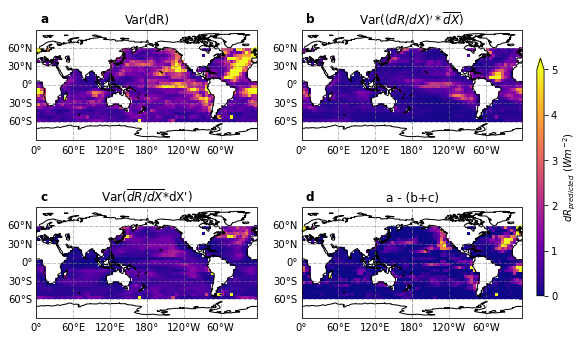

In [16]:
#figcheck 
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree(central_longitude=180.0))


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(), ax4.coastlines()

im=dR_hat_var.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False,vmax=5,vmin=0)
dR_sensitivity_var.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5,vmin=0)
dR_intrin_var.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=5,vmin=0)
var_diff.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma',extend='max',add_colorbar=False,vmax=5,vmin=0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.22, 0.01, 0.55])
fig.colorbar(im, cax=cbar_ax, label='$dR_{predicted}$ ($Wm^{-2}$)',extend='max')

#ax.set_title("Var(dR), Var((dR/dX)'$\overline{dX}$) and $dX'*\overline{dR/dX}$ across 60S to 60N (1982-2008)")
ax1.set_title('Var(dR)')
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)")
ax3.set_title("Var($\overline{dR/dX}$*dX')")
ax4.set_title("a - (b+c)")
make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/var_dR_sensitivity_intrin_diff_4maps_hist_2008_cartopy.png', dpi=300,bbox_inches='tight')

## Standard Deviation for all terms

In [17]:
# Model SST Sensitivity
dR_model_to_sst_prime_std = dR_model_to_sst_prime.to_array(dim='models').std('models')
dR_model_to_sst_prime_std_cmip5 = dR_model_to_sst_prime_cmip5.to_array(dim='models').std('models')
dR_model_to_sst_prime_std_cmip6 = dR_model_to_sst_prime_cmip6.to_array(dim='models').std('models')


# Intrinsic EIS changes 
dR_intrin_eis_prime_std = dR_intrin_eis_prime.to_array(dim='models').std('models')
dR_intrin_eis_prime_std_cmip5 = dR_intrin_eis_prime_cmip5.to_array(dim='models').std('models')
dR_intrin_eis_prime_std_cmip6 = dR_intrin_eis_prime_cmip6.to_array(dim='models').std('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_std = dR_model_to_eis_prime.to_array(dim='models').std('models')
dR_model_to_eis_prime_std_cmip5 = dR_model_to_eis_prime_cmip5.to_array(dim='models').std('models')
dR_model_to_eis_prime_std_cmip6 = dR_model_to_eis_prime_cmip6.to_array(dim='models').std('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_std = dR_intrin_tadv_prime.to_array(dim='models').std('models')
dR_intrin_tadv_prime_std_cmip5 = dR_intrin_tadv_prime_cmip5.to_array(dim='models').std('models')
dR_intrin_tadv_prime_std_cmip6 = dR_intrin_tadv_prime_cmip6.to_array(dim='models').std('models')


# Model Tadv Sensitivity 
dR_model_to_tadv_prime_std = dR_model_to_tadv_prime.to_array(dim='models').std('models')
dR_model_to_tadv_prime_std_cmip5 = dR_intrin_tadv_prime_cmip5.to_array(dim='models').std('models')
dR_model_to_tadv_prime_std_cmip6 = dR_intrin_tadv_prime_cmip6.to_array(dim='models').std('models')


# Intrinsic RH changes 
dR_intrin_rh_prime_std = dR_intrin_rh_prime.to_array(dim='models').std('models')
dR_intrin_rh_prime_std_cmip5 = dR_intrin_rh_prime_cmip5.to_array(dim='models').std('models')
dR_intrin_rh_prime_std_cmip6 = dR_intrin_rh_prime_cmip6.to_array(dim='models').std('models')


# Model RH Sensitivity 
dR_model_to_rh_prime_std = dR_model_to_rh_prime.to_array(dim='models').std('models')
dR_model_to_rh_prime_std_cmip5 = dR_model_to_rh_prime_cmip5.to_array(dim='models').std('models')
dR_model_to_rh_prime_std_cmip6 = dR_model_to_rh_prime_cmip6.to_array(dim='models').std('models')


# Intrinsic Omega changes 
dR_intrin_omega_prime_std = dR_intrin_omega_prime.to_array(dim='models').std('models')
dR_intrin_omega_prime_std_cmip5 = dR_intrin_omega_prime_cmip5.to_array(dim='models').std('models')
dR_intrin_omega_prime_std_cmip6 = dR_intrin_omega_prime_cmip6.to_array(dim='models').std('models')


# Model Omega Sensitivity 
dR_model_to_omega_prime_std = dR_model_to_omega_prime.to_array(dim='models').std('models')
dR_model_to_omega_prime_std_cmip5 = dR_model_to_omega_prime_cmip5.to_array(dim='models').std('models')
dR_model_to_omega_prime_std_cmip6 = dR_model_to_omega_prime_cmip6.to_array(dim='models').std('models')


# Intrinsic WS changes 
dR_intrin_ws_prime_std = dR_intrin_ws_prime.to_array(dim='models').std('models')
dR_intrin_ws_prime_std_cmip5 = dR_intrin_ws_prime_cmip5.to_array(dim='models').std('models')
dR_intrin_ws_prime_std_cmip6 = dR_intrin_ws_prime_cmip6.to_array(dim='models').std('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_std = dR_model_to_ws_prime.to_array(dim='models').std('models')
dR_model_to_ws_prime_std_cmip5 = dR_model_to_ws_prime_cmip5.to_array(dim='models').std('models')
dR_model_to_ws_prime_std_cmip6 = dR_model_to_ws_prime_cmip6.to_array(dim='models').std('models')

sum_of_terms = dR_model_to_sst_prime+dR_intrin_eis_prime+dR_model_to_eis_prime+dR_intrin_tadv_prime+dR_model_to_tadv_prime+dR_intrin_rh_prime+dR_model_to_rh_prime+dR_intrin_omega_prime+dR_model_to_omega_prime+dR_intrin_ws_prime+dR_model_to_ws_prime
sum_of_terms_std = sum_of_terms.to_array(dim='models').std('models')
dR_hat_std = dR_hat.to_array(dim='models').std('models')
ratio_sumofterms_dR_hat = sum_of_terms_std/dR_hat_std

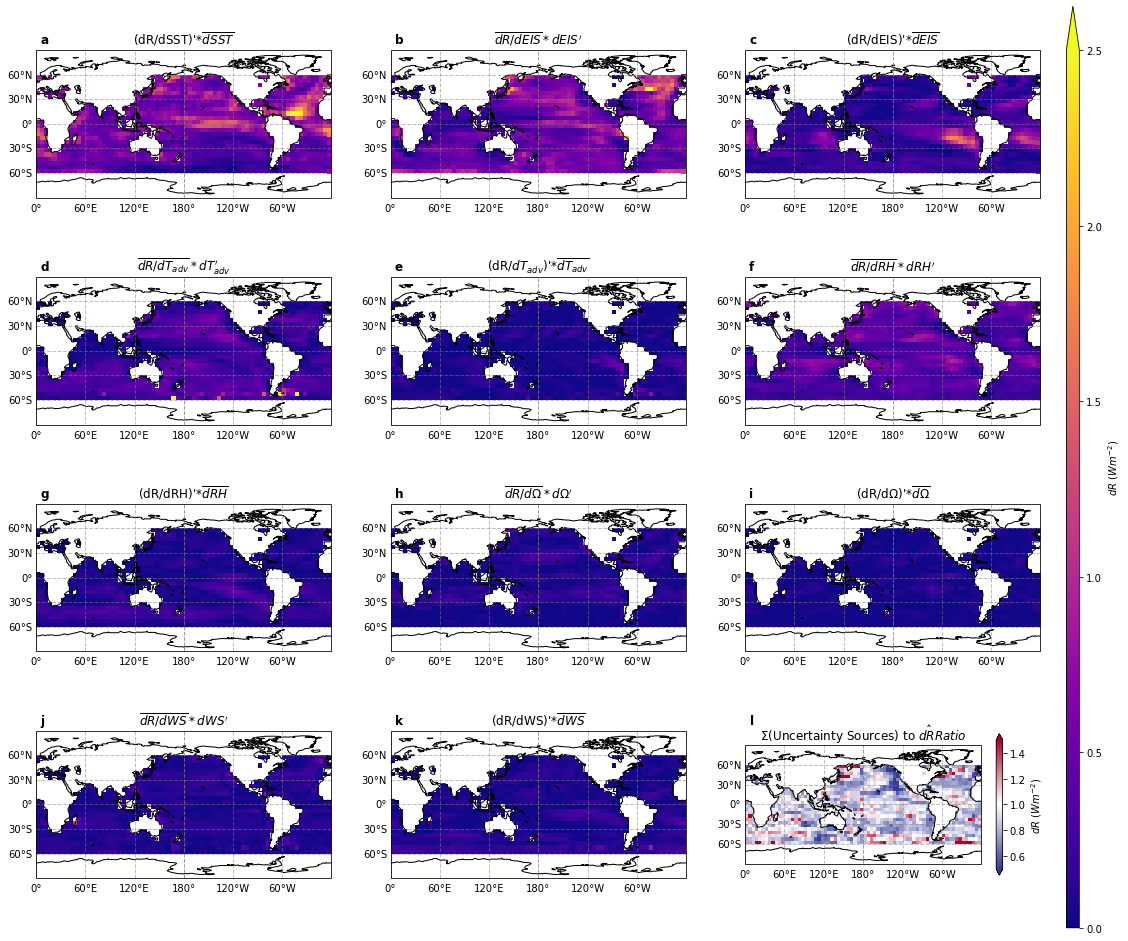

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
#figcheck 
fig = plt.figure(figsize=(18,16))
ax1 = plt.subplot2grid((4,3), (0,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = plt.subplot2grid((4,3), (0,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = plt.subplot2grid((4,3), (0,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = plt.subplot2grid((4,3), (1,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = plt.subplot2grid((4,3), (1,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = plt.subplot2grid((4,3), (1,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax7 = plt.subplot2grid((4,3), (2,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax8 = plt.subplot2grid((4,3), (2,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax9 = plt.subplot2grid((4,3), (2,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax10 = plt.subplot2grid((4,3), (3,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax11 = plt.subplot2grid((4,3), (3,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax12 = plt.subplot2grid((4,3), (3,2), projection=ccrs.PlateCarree(central_longitude=180.0))
#fig.suptitle('Standard Deviation of Sources of Uncertainty');


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7.xlabels_top = False
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl8.xlabels_top = False
gl9 = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl9.xlabels_top = False
gl10 = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl10.xlabels_top = False
gl11 = ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl11.xlabels_top = False
gl12 = ax12.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl12.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines(),ax7.coastlines(), ax8.coastlines(), ax9.coastlines(),ax10.coastlines(), ax11.coastlines(), ax12.coastlines()

dR_model_to_sst_prime_std.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma', add_colorbar=False, vmin=0, vmax=2.5)
dR_intrin_eis_prime_std.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5,add_colorbar=False)
im = dR_model_to_eis_prime_std.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5 ,add_colorbar=False)#,vmax=3.2,
dR_intrin_tadv_prime_std.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5, add_colorbar=False)#,vmax=3.2)
dR_model_to_tadv_prime_std.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5 ,add_colorbar=False)#,vmax=3.2)
dR_intrin_rh_prime_std.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5,add_colorbar=False)#,vmax=3.2)
dR_model_to_rh_prime_std.plot(ax=ax7,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5 , add_colorbar=False)#,vmax=3.2)
dR_intrin_omega_prime_std.plot(ax=ax8,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5 ,add_colorbar=False)#,vmax=3.2)
dR_model_to_omega_prime_std.plot(ax=ax9,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5 ,add_colorbar=False)#,vmax=3.2)
dR_intrin_ws_prime_std.plot(ax=ax10,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5, add_colorbar=False)#,vmax=3.2)
dR_model_to_ws_prime_std.plot(ax=ax11,transform=ccrs.PlateCarree(),cmap='plasma', vmin=0, vmax=2.5 ,add_colorbar=False)#,vmax=3.2)

colors = [cm.RdYlBu(.99), "white", cm.RdYlBu(.01) ]
nodes = [0.0, 0.5, 1.]
cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
ratio_sumofterms_dR_hat.plot(ax=ax12,transform=ccrs.PlateCarree(),cmap=cmap,cbar_kwargs={'shrink': 0.75,'label':'$dR$ ($Wm^{-2}$)'},vmin=0.5, vmax=1.5,extend='both')

cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
fig.colorbar(im, cax=cbar_ax, label='$dR$ ($Wm^{-2}$)',ticks=np.arange(0,3,.5),extend='max')


ax1.set_title("(dR/dSST)'*$\overline{dSST}$")
ax2.set_title("$\overline{dR/dEIS}*dEIS'$")
ax3.set_title("(dR/dEIS)'*$\overline{dEIS}$")
ax4.set_title("$\overline{dR/dT_{adv}}*dT_{adv}'$")
ax5.set_title("(dR/$dT_{adv}$)'*$\overline{dT_{adv}}$")
ax6.set_title("$\overline{dR/dRH}*dRH'$")
ax7.set_title("(dR/dRH)'*$\overline{dRH}$")
ax8.set_title("$\overline{dR/d\u03a9}*d\u03a9'$")
ax9.set_title("(dR/d\u03a9)'*$\overline{d\u03a9}$")
ax10.set_title("$\overline{dR/dWS}*dWS'$")
ax11.set_title("(dR/dWS)'*$\overline{dWS}$")
ax12.set_title('\u03A3(Uncertainty Sources) to $\hat{dR} Ratio$')

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')
make_textbox(ax7,'g')
make_textbox(ax8,'h')
make_textbox(ax9,'i')
make_textbox(ax10,'j')
make_textbox(ax11,'k')
ax12.text(0.676,0.277,'l',weight='bold',transform=fig.transFigure,fontsize=12)

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/hist/final/std_uncertainty_12maps_singcolorbar_hist_2008_cartopy.png',  dpi=300, bbox_inches='tight')